In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from db import base_db_interface

raw_df = base_db_interface.read("bfo_espn_ufc_features")
for dt_col in ["Date", "DOB", "DOB_opp"]:
    raw_df[dt_col] = pd.to_datetime(raw_df[dt_col])
raw_df[["FighterOpen", "OpponentOpen"]] = raw_df[["FighterOpen", "OpponentOpen"]]\
    .astype(float)

raw_df = raw_df.drop_duplicates(subset=["FighterID_espn", "OpponentID_espn", "fight_id"])
raw_df["FighterID_espn"] = raw_df["FighterID_espn"].fillna("unknown")
raw_df["OpponentID_espn"] = raw_df["OpponentID_espn"].fillna("unknown")
print(raw_df.shape)
raw_df.head() # show the first 5 rows

(137372, 248)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,prev_weight,FighterID_espn_opp,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,2354059,0,0,0,NaN,0.0,185.0,185.0,NaN
1,1991-09-26_2354059_2558095,1991-09-26,W,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2558095,2354059,NaN,...,NaN,2558095,0,0,0,NaN,0.0,NaN,NaN,NaN
2,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,2501396,0,0,0,NaN,0.0,185.0,185.0,NaN
3,1992-01-01_2354119_2501396,1992-01-01,L,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2354119,2501396,NaN,...,NaN,2354119,0,0,0,NaN,0.0,170.0,170.0,NaN
4,1993-08-29_2354132_3107994,1993-08-29,W,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,3107994,2354132,NaN,...,NaN,3107994,0,0,0,NaN,0.0,NaN,NaN,NaN


# Awful, Ugly, Stinky, No-Good Hack

Necessary in order to get data for the upcoming fights. The join is very difficult

In [4]:
from wrangle.clean_espn_data import EspnDataCleaner

# Get odds for upcoming fight
bfo_df = base_db_interface.read("clean_fighter_odds_data")
bfo_df["Date"] = pd.to_datetime(bfo_df["Date"])
bfo_to_espn_map = base_db_interface.read("bfo_to_espn_map")
# upcoming_bfo_df = bfo_df.query("EventHref == \
#                                '/events/ufc-fight-night-holloway-vs-allen-2796'")
# is_upcoming = bfo_df["EventHref"].apply(
#     lambda x: not (x == raw_df["EventHref"]).any()
# )
is_upcoming = bfo_df["Date"] > pd.to_datetime("2023-08-18")
# is_upcoming = bfo_df["EventHref"].apply(
#     lambda x: x.isin([
#         "/events/ufc-292-sterling-vs-o-malley-2899",
#         "/events/ufc-2990"
#     ])
# )
upcoming_bfo_df = bfo_df.loc[is_upcoming]
upcoming_bfo_df = upcoming_bfo_df.rename(
    columns={"FighterID": "FighterID_bfo", "OpponentID": "OpponentID_bfo"}
)
print(upcoming_bfo_df.shape)
upcoming_bfo_df = upcoming_bfo_df.merge(
    bfo_to_espn_map[["FighterID_bfo", "FighterID_espn"]].drop_duplicates(),
    on=["FighterID_bfo"],
    how="left"
).merge(
    bfo_to_espn_map[["OpponentID_bfo", "OpponentID_espn"]].drop_duplicates(),
    on=["OpponentID_bfo"],
    how="left"
)

print(upcoming_bfo_df.shape)
# Get bios for fighters in upcoming fight
espn_dc = EspnDataCleaner()
espn_dc._parse_bios()
espn_dc.clean_bio_df
bio_df = espn_dc.clean_bio_df.rename(columns={
    "FighterID":"FighterID_espn", "Name": "BioName",
})
upcoming_bfo_df = upcoming_bfo_df.merge(
    bio_df,
    left_on="FighterID_espn",
    right_on="FighterID_espn",
    how="left",
    suffixes=("_dropme", "")
).merge(
    bio_df,
    left_on="OpponentID_espn",
    right_on="FighterID_espn",
    how="left",
    suffixes=("", "_opp")
)
print(upcoming_bfo_df.shape)

upcoming_bfo_df.head()

(104, 17)
(104, 19)
(104, 40)


,Event,EventHref,Date,FighterID_bfo,OpponentID_bfo,FighterName,OpponentName,FighterOpen,OpponentOpen,FighterCloseLeft,...,BioName_opp,FighterID_espn_opp,Country_opp,WT Class_opp,Team_opp,Nickname_opp,ReachInches_opp,WeightPounds_opp,HeightInches_opp,DOB_opp
0,Bellator vs RIZIN,/events/bellator-vs-rizin-2753,2023-10-31,A-J-McKee-5567,Roberto-de-Souza-9036,a.j. mckee,roberto de souza,-145,+115,-250,...,roberto de souza,4413120,Brazil,Lightweight,Bonsai Jiu-Jitsu,Satoshi,NaN,155.0,70.0,1989-09-19
1,Professional Fighters League,/events/professional-fighters-league-2996,2023-08-19,Abraham-Bably-14256,Anthony-Wint-16320,abraham bably,anthony wint,-175,+130,-175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,KSW,/events/ksw-2984,2023-08-19,Adrianna-Kreft-14189,Yasmin-Guimaraes-15389,adrianna kreft,yasmin guimaraes,-163,+125,-163,...,yasmin guimarães,5135542,Brazil,Women's Flyweight,MSP,None,NaN,125.0,65.0,1995-11-30
3,UFC on ESPN: Holloway vs. The Korean Zombie,/events/ufc-on-espn-holloway-vs-the-korean-zom...,2023-08-26,Alex-Caceres-2247,Giga-Chikadze-6073,alex caceres,giga chikadze,+150,-180,+170,...,giga chikadze,3957071,Georgia,Featherweight,Kings MMA,Ninja,74.0,146.0,72.0,1988-08-25
4,UFC Fight Night: Grasso vs. Shevchenko 2,/events/ufc-fight-night-grasso-vs-shevchenko-2...,2023-09-16,Alexa-Grasso-5096,Valentina-Shevchenko-5475,alexa grasso,valentina shevchenko,+210,-250,+175,...,valentina shevchenko,2554705,Kyrgyzstan,Women's Flyweight,Tiger Muay Thai,Bullet,66.5,125.0,65.0,1988-03-07


In [5]:
# don't like this line, 
df = raw_df.merge(
    upcoming_bfo_df,
    on=["FighterID_espn", "OpponentID_espn", "Date"],
    how="left",
    suffixes=("", "_dropme")
)
drop_cols = df.columns[df.columns.str.endswith("_dropme")]
for drop_col in drop_cols:
    col = drop_col[:-len("_dropme")]
    df[col] = df[col].fillna(df[drop_col])
df = df.drop(columns=drop_cols)
print(raw_df.shape, df.shape)
foo = df.query("EventHref == '/events/ufc-292-sterling-vs-o-malley-2899' | \
               EventHref == '/events/ufc-2990'")
print("shape of tonight's fight:", foo.shape)
foo.head()

(137372, 248) (137372, 250)
shape of tonight's fight: (12, 250)


,fight_id,Date,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,n_career_fights_opp,n_ufc_fights_opp,t_since_first_fight_opp,t_since_prev_fight_opp,total_ufc_cage_time_opp,min_weight_opp,max_weight_opp,prev_weight_opp,BioName,BioName_opp
137244,2023-08-19_3281606_3309918,2023-08-19,None,None,None,None,UFC 292: Sterling vs O'Malley,3281606,3309918,NaN,...,15,10,3556,273.0,2697.0,NaN,NaN,125.0,karine silva,maryna moroz
137245,2023-08-19_3281606_3309918,2023-08-19,None,None,None,None,UFC 292: Sterling vs O'Malley,3309918,3281606,NaN,...,20,2,3717,77.0,504.0,NaN,NaN,125.0,maryna moroz,karine silva
137248,2023-08-19_3153106_4054605,2023-08-19,None,None,None,None,UFC 292: Sterling vs O'Malley,3153106,4054605,NaN,...,20,10,3256,147.0,2992.0,NaN,NaN,125.0,natalia silva,andrea lee
137250,2023-08-19_2553261_4697476,2023-08-19,None,None,None,None,UFC 292: Sterling vs O'Malley,4697476,2553261,NaN,...,11,4,1779,280.0,854.0,NaN,NaN,185.0,gerald meerschaert,andre petroski
137251,2023-08-19_3019246_4397797,2023-08-19,None,None,None,None,UFC 292: Sterling vs O'Malley,3019246,4397797,NaN,...,28,4,4543,11.0,0.0,NaN,NaN,155.0,austin hubbard,kurt holobaugh


In [6]:
df["Date"].max()

Timestamp('2023-11-11 00:00:00')

# Elo Alphas

Iterate over all elo alphas. Ignore PCA stuff for now

## Defining some targets for Elo estimators along the way

In [7]:
df["win_target"] = df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})
df["win_target"].value_counts(dropna=False)

win_target
0.0    67376
1.0    67376
NaN     2620
Name: count, dtype: int64

In [8]:
# have to parse the decision column to get the detailed result
def parse_decision(s):
    if (s.startswith("submission") or 
        s.startswith("sumission") or
        s.startswith("technical submission")
    ):
        return "submission"
    if (s.startswith("tko") or 
        s.startswith("ko") or
        (s == 'could not continue')
    ):
        return "tko_ko"
    if "decision" in s:
        return "decision"
    return "other"

temp_decision = df["Decision"].fillna("-").str.lower().str.strip()
decision_clean = temp_decision.apply(parse_decision)
result_sign = df["FighterResult"].map({"W": 1, "L":-1, "D": 0})
decision_score = decision_clean.map({"tko_ko":2, "submission":2, 
                                                    "decision":1, "other":0})
df["ordinal_fighter_result"] = result_sign * decision_score
submission_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":0})
tko_ko_score = decision_clean.map({"submission":0, "decision":0, 
                                            "other":0, "tko_ko":1})
decision_score = decision_clean.map({"submission":0, "decision":1, 
                                            "other":0, "tko_ko":0})
finish_score = decision_clean.map({"submission":1, "decision":0, 
                                            "other":0, "tko_ko":1})
df["submission_fighter_result"] = result_sign * submission_score
df["tko_ko_fighter_result"] = result_sign * tko_ko_score
df["decision_fighter_result"] = result_sign * decision_score
df["finish_fighter_result"] = result_sign * finish_score

df["win_target_finish"] = df["win_target"] * decision_clean.map({
    "submission":1, "tko_ko":1,
    "decision":np.nan, "other":np.nan, 
})
df["win_target_finish"].value_counts(dropna=False)

win_target_finish
0.0    46859
1.0    46859
NaN    43654
Name: count, dtype: int64

In [9]:
def parse_fight_time(row):
    if not np.isnan(row["time_dur"]):
        return row["time_dur"]
    if row["Rnd"] == "-":
        return np.nan
    if row["Time"] == "-":
        # assuming 5 minute rounds
        # fill in something for now
        return int(row["Rnd"]) * 5 * 60
    n_rounds = row["Rnd"].strip()
    min, sec = row["Time"].strip().split(":")
    if n_rounds == "-":
        return np.nan
    n_rounds = int(n_rounds) - 1
    if (min == "-") | (sec == "-"):
        return np.nan
    min = int(min)
    sec = int(sec)
    # assuming 5 minute rounds
    return (n_rounds * 5 * 60) + min * 60 + sec
    
df["Rnd"] = df["Rnd"].fillna("-")
df["Time"] = df["Time"].fillna("-")
df["fight_time"] = df.apply(parse_fight_time, axis=1)
df["fight_time"].notnull().mean()

0.9894447194479224

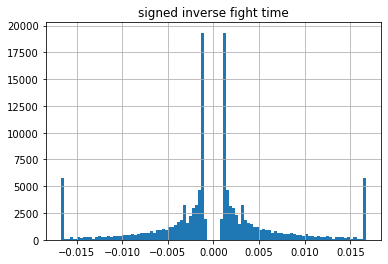

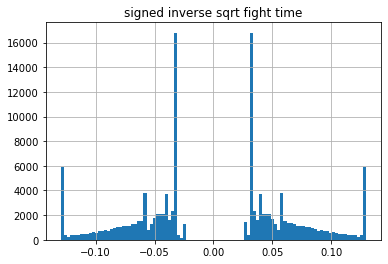

In [10]:
y = (-1)**df["win_target"]
# restrict btw 1 and 25 minutes (length of a title fight)
# short fight times -> big outliers
clipped_time_dur = df["fight_time"].clip(60, (5*5*60))
df["signed_inverse_fight_time"] = y / clipped_time_dur
df["signed_inverse_sqrt_fight_time"] = y / np.sqrt(clipped_time_dur)
df["signed_inverse_log_fight_time"] = y / np.log(clipped_time_dur)

df["signed_inverse_fight_time"].hist(bins=100)
plt.title("signed inverse fight time")
plt.show()

df["signed_inverse_sqrt_fight_time"].hist(bins=100)
plt.title("signed inverse sqrt fight time")
plt.show()

# Simpler features

In [11]:
from model.mma_elo_model import unknown_fighter_id
from tqdm import tqdm


def get_simple_features(df):
    # simple things that i needn't get from the fighter stats page
    # eg number of fights, t_since_last_fight
    assert (df["fight_id"].value_counts() == 2).all()
    df = df.assign(
        is_ufc=df["Event"].fillna("").str.contains("UFC"),
        Date=pd.to_datetime(df["Date"]),
    )
    feat_df = df.sort_values("Date").copy()[[
        "fight_id", "FighterID_espn", "OpponentID_espn", "Date", "is_ufc"
    ]]
    # Rolling features over fighter_careers
    # because the data is doubled, we can simply group by the fighter id
    feat_df["dummy"] = 1
    # total fights
    feat_df["total_fights"] = feat_df.groupby("FighterID_espn")["dummy"].cumsum()
    feat_df["total_fights_opp"] = feat_df.groupby("OpponentID_espn")["dummy"].cumsum()
    # total ufc fights
    feat_df["total_ufc_fights"] = feat_df.groupby("FighterID_espn")["is_ufc"].cumsum()
    feat_df["total_ufc_fights_opp"] = feat_df.groupby("OpponentID_espn")["is_ufc"].cumsum()
    # time since last fight
    feat_df["t_since_last_fight"] = feat_df.groupby("FighterID_espn")["Date"].diff().dt.days
    feat_df["t_since_last_fight_opp"] = feat_df.groupby("OpponentID_espn")["Date"].diff().dt.days
    fill_val = 2*365 # arbitrarily say 2 years
    feat_df["t_since_last_fight"] = np.maximum(fill_val, feat_df["t_since_last_fight"].fillna(fill_val))   
    feat_df["t_since_last_fight_opp"] = np.maximum(fill_val, feat_df["t_since_last_fight_opp"].fillna(fill_val)) 
    # time since first fight
    feat_df["t_since_first_fight"] = (feat_df["Date"] - feat_df.groupby("FighterID_espn")["Date"].transform("min")).dt.days
    feat_df["t_since_first_fight_opp"] = (feat_df["Date"] - feat_df.groupby("OpponentID_espn")["Date"].transform("min")).dt.days
    # compute diffs
    feat_df["t_since_last_fight_diff"] = (feat_df["t_since_last_fight"] - 
                                            feat_df["t_since_last_fight_opp"])
    feat_df["t_since_last_fight_log_diff"] = (np.log(feat_df["t_since_last_fight"]) - 
                                                np.log(feat_df["t_since_last_fight_opp"]))
    feat_df["total_fights_diff"] = (feat_df["total_fights"] - 
                                    feat_df["total_fights_opp"])
    feat_df["total_fights_sqrt_diff"] = (np.sqrt(feat_df["total_fights"]) - 
                                        np.sqrt(feat_df["total_fights_opp"]))
    feat_df["total_ufc_fights_diff"] = (feat_df["total_ufc_fights"] - 
                                        feat_df["total_ufc_fights_opp"])
    feat_df["total_ufc_fights_sqrt_diff"] = (np.sqrt(feat_df["total_ufc_fights"]) - 
                                                np.sqrt(feat_df["total_ufc_fights_opp"]))
    
    return feat_df

simple_feat_df = get_simple_features(df)
print(simple_feat_df.shape, df.shape)

(137372, 20) (137372, 261)


In [12]:
simple_feat_df.columns, df.columns

(Index(['fight_id', 'FighterID_espn', 'OpponentID_espn', 'Date', 'is_ufc',
        'dummy', 'total_fights', 'total_fights_opp', 'total_ufc_fights',
        'total_ufc_fights_opp', 't_since_last_fight', 't_since_last_fight_opp',
        't_since_first_fight', 't_since_first_fight_opp',
        't_since_last_fight_diff', 't_since_last_fight_log_diff',
        'total_fights_diff', 'total_fights_sqrt_diff', 'total_ufc_fights_diff',
        'total_ufc_fights_sqrt_diff'],
       dtype='object'),
 Index(['fight_id', 'Date', 'FighterResult', 'Decision', 'Rnd', 'Time', 'Event',
        'OpponentID_espn', 'FighterID_espn', 'TSL',
        ...
        'ordinal_fighter_result', 'submission_fighter_result',
        'tko_ko_fighter_result', 'decision_fighter_result',
        'finish_fighter_result', 'win_target_finish', 'fight_time',
        'signed_inverse_fight_time', 'signed_inverse_sqrt_fight_time',
        'signed_inverse_log_fight_time'],
       dtype='object', length=261))

In [13]:
feat_ml_df = df.merge(
    simple_feat_df, 
    how="left",
    on=["FighterID_espn", "OpponentID_espn", "fight_id"],
    suffixes=("_legacy", ""),
)

feat_ml_df["age_diff"] = (feat_ml_df["DOB"] - feat_ml_df["DOB_opp"]).dt.days / 365
feat_ml_df["age_diff"] = feat_ml_df["age_diff"].fillna(0)

feat_ml_df["log_reach_diff"] = (
    np.log(feat_ml_df["ReachInches"]) - np.log(feat_ml_df["ReachInches_opp"])
).fillna(0)
feat_ml_df["weight_diff"] = (
    feat_ml_df["min_weight"] - feat_ml_df["min_weight_opp"]
).fillna(0)
feat_ml_df["height_diff"] = (
    feat_ml_df["HeightInches"] - feat_ml_df["HeightInches_opp"]
).fillna(0)

feat_ml_df["t_since_first_fight_diff"] = (
    feat_ml_df["t_since_first_fight"] - feat_ml_df["t_since_first_fight_opp"]
).fillna(0)

feat_ml_df["is_first_fight_diff"] = (
    (feat_ml_df["t_since_first_fight"] == 0).astype(int) -
    (feat_ml_df["t_since_first_fight_opp"] == 0).astype(int)
).fillna(0) # shouldn't be any nulls, but just in case

feat_ml_df["log_t_since_first_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_first_fight"]) - 
    np.log(1 + feat_ml_df["t_since_first_fight_opp"])
).fillna(0)

feat_ml_df["log_t_since_prev_fight_diff"] = (
    np.log(1 + feat_ml_df["t_since_prev_fight"]) -
    np.log(1 + feat_ml_df["t_since_prev_fight_opp"])
).fillna(0)

# whether or not the fighter is from the USA
feat_ml_df["usa_diff"] = (
    feat_ml_df["Country"].str.strip().str.lower().str.contains("usa") -
    feat_ml_df["Country_opp"].str.strip().str.lower().str.contains("usa")
).fillna(0)

feat_ml_df["russia_diff"] = (
    feat_ml_df["Country"].str.strip().str.lower().str.contains("russia") -
    feat_ml_df["Country_opp"].str.strip().str.lower().str.contains("russia")
).fillna(0)

stance_fighter_clean = feat_ml_df["Stance"].fillna("orthodox").str.strip().str.lower()
stance_fighter_clean.loc[~stance_fighter_clean.isin(["southpaw", "switch"])] = "orthodox"
stance_opp_clean = feat_ml_df["Stance_opp"].fillna("orthodox").str.strip().str.lower()
stance_opp_clean.loc[~stance_opp_clean.isin(["southpaw", "switch"])] = "orthodox"

# advantage to fighter with the weirder stance
feat_ml_df["stance_diff"] = (
    (stance_fighter_clean == "southpaw") & (stance_opp_clean == "orthodox") |
    (stance_fighter_clean == "switch") & (stance_opp_clean == "orthodox")
).astype(int) - (
    (stance_fighter_clean == "orthodox") & (stance_opp_clean == "southpaw") |
    (stance_fighter_clean == "orthodox") & (stance_opp_clean == "switch")
).astype(int)


feat_ml_df["ape_index"] = feat_ml_df["ReachInches"] / feat_ml_df["HeightInches"]
feat_ml_df["ape_index_opp"] = feat_ml_df["ReachInches_opp"] / feat_ml_df["HeightInches_opp"]
feat_ml_df["ape_index_diff"] = (feat_ml_df["ape_index"] - feat_ml_df["ape_index_opp"]).fillna(0)

feat_ml_df["bmi"] = feat_ml_df["fight_weight"] / (feat_ml_df["HeightInches"] ** 2) * 703
feat_ml_df["bmi_opp"] = feat_ml_df["fight_weight"] / (feat_ml_df["HeightInches_opp"] ** 2) * 703
feat_ml_df["bmi_diff"] = (feat_ml_df["bmi"] - feat_ml_df["bmi_opp"]).fillna(0)

# new_feat_cols = [*feat_cols, "ml_logit"]
# feat_cols
feat_ml_df.columns

Index(['fight_id', 'Date_legacy', 'FighterResult', 'Decision', 'Rnd', 'Time',
       'Event', 'OpponentID_espn', 'FighterID_espn', 'TSL',
       ...
       'log_t_since_prev_fight_diff', 'usa_diff', 'russia_diff', 'stance_diff',
       'ape_index', 'ape_index_opp', 'ape_index_diff', 'bmi', 'bmi_opp',
       'bmi_diff'],
      dtype='object', length=295)

# Define some auxiliary targets

In [14]:
feat_ml_df[["SSA", "SSL"]].dropna()

,SSA,SSL
12,3.0,0.0
13,0.0,0.0
14,3.0,0.0
15,1.0,1.0
16,8.0,4.0
...,...,...
137219,11.0,4.0
137220,16.0,6.0
137221,3.0,0.0
137222,47.0,22.0


In [15]:
feat_ml_df["SS_fail"] = feat_ml_df["SSA"] - feat_ml_df["SSL"]
feat_ml_df["SS_fail_opp"] = feat_ml_df["SSA_opp"] - feat_ml_df["SSL_opp"]
feat_ml_df["TS_fail"] = feat_ml_df["TSA"] - feat_ml_df["TSL"]
feat_ml_df["TS_fail_opp"] = feat_ml_df["TSA_opp"] - feat_ml_df["TSL_opp"]
feat_ml_df["SL_fail"] = feat_ml_df["SLA"] - feat_ml_df["SLL"]
feat_ml_df["SL_fail_opp"] = feat_ml_df["SLA_opp"] - feat_ml_df["SLL_opp"]
feat_ml_df["SH_fail"] = feat_ml_df["SHA"] - feat_ml_df["SHL"]
feat_ml_df["SH_fail_opp"] = feat_ml_df["SHA_opp"] - feat_ml_df["SHL_opp"]

# diff in control time, normalized for fight duration
feat_ml_df["percent_ctrl_time_diff"] = (
    (feat_ml_df["ctrl_seconds"] - feat_ml_df["ctrl_seconds_opp"]) / feat_ml_df["time_dur"]
).fillna(0)

# TODO I could do PCA on all attempts, and use the first component as a feature
# but for now I'll just weight them arbitrarily
feat_ml_df["cardio"] = feat_ml_df["TSA"] + 10*feat_ml_df["TDA"]
feat_ml_df["cardio_opp"] = feat_ml_df["TSA_opp"] + 10*feat_ml_df["TDA_opp"]
feat_ml_df["cardio_diff"] = feat_ml_df["cardio"] - feat_ml_df["cardio_opp"]

/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3886026141.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat_ml_df["percent_ctrl_time_diff"] = (
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3886026141.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat_ml_df["cardio"] = feat_ml_df["TSA"] + 10*feat_ml_df["TDA"]
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3886026141.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [16]:
stat_cols = [
    'TSL', 'TSA', 'SSL',
    'SSA', #'TSL-TSA', 
    'KD', #'%BODY', '%HEAD', '%LEG', 
    'SCBL',
    'SCBA', 'SCHL', 'SCHA', 'SCLL', 'SCLA', 'RV', 'TDL', 'TDA', 'TDS',
    # 'TK ACC', 'SR', # I don't believe in ratio features in PCA, 
    # # because of the possibility of division by zero and heteroskedasticity
    'SGBL', 'SGBA', 'SGHL', 'SGHA', 'SGLL', 'SGLA', 'AD', 'ADTB',
    'ADHG', 'ADTM', 'ADTS', 'SM', 'SDBL', 'SDBA', 'SDHL',
    'SDHA', 'SDLL', 'SDLA',
    #'time_seconds',
    # 'TD_fails', #'submission_rate',
    'TD_fail', "SS_fail", "SM_fail", "TS_fail",  # formerly 'TD_fails'
    'SDL', 'SCL', # formerly 'distance_strikes_landed', 'clinch_strikes_landed',
    #'KD_power', 
    'SGL', # formerly 'ground_strikes_landed'
    "cardio",
]
diff_cols = [col+"_diff" for col in stat_cols]
for col, diff_col in zip(stat_cols, diff_cols):
    if feat_ml_df[col].dtype == "object":
        feat_ml_df[col] = feat_ml_df[col].str.strip().astype(float)
    if feat_ml_df[col+"_opp"].dtype == "object":
        feat_ml_df[col+"_opp"] = feat_ml_df[col+"_opp"].str.strip().astype(float)
    
    feat_ml_df[diff_col] = (
        np.sqrt(np.maximum(0, feat_ml_df[col])) - 
        np.sqrt(np.maximum(0, feat_ml_df[col+"_opp"]))
    ) 
    # I shouldn't have to fillna here...

/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/2170616793.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat_ml_df[diff_col] = (
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/2170616793.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feat_ml_df[diff_col] = (
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/2170616793.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

# Join with closing line data

In [17]:
# Joining the closing line too
close_df = base_db_interface.read("clean_bfo_close_data")
display(close_df.head())
close_df.columns

MARKETS = [
    "DraftKings", "BetMGM", "Caesars",
    "BetRivers", "FanDuel", "PointsBet",
    "Unibet", "BetWay", "5D",
    # "Ref", 
    "Bet365",
]
def join_close_data(df, close_df):
    """
    Join closing odds data to the main dataframe.
    """
    # Identification of the "Fighter" and the "Opponent" is not consistent
    # across the two dataframes. So for each row in close_df, we make a copy
    # with the "Fighter" and "Opponent" columns swapped. Then we can simply
    # join the two dataframes together and have the closing odds correspond
    # to the correct fighter.

    assert (df["fight_id"].value_counts() == 2).all()
    print(close_df[["EventHref", "FighterID", "OpponentID"]].value_counts().value_counts())
    a = np.maximum(close_df["FighterID"], close_df["OpponentID"])
    b = np.minimum(close_df["FighterID"], close_df["OpponentID"])
    temp_id = close_df["EventHref"].str.cat(a, sep="_").str.cat(b, sep="_")
    assert (temp_id.value_counts() == 2).all()
    # ^ if this condition holds, then the data is already doubled!

    # assert (close_df[["EventHref", "FighterID", "OpponentID"]].value_counts() == 1).all()
    # complement_cols = {
    #     "FighterName": "OpponentName",
    #     "FighterID": "OpponentID",
    #     "OpponentName": "FighterName",
    #     "OpponentID": "FighterID",
    #     **{
    #         (col+"_fighter"): (col+"_opponent")
    #         for col in MARKETS
    #     },
    #     **{
    #         (col+"_opponent"): (col+"_fighter")
    #         for col in MARKETS
    #     }
    # }
    # doubled_close_df = pd.concat([
    #     close_df,
    #     close_df.rename(columns=complement_cols)
    # ]).reset_index(drop=True)
    # assert (df["fight_id"].value_counts() == 2).all()
    # print(doubled_close_df[["EventHref", "FighterID", "OpponentID"]].value_counts())
    # assert (doubled_close_df[["EventHref", "FighterID", "OpponentID"]].value_counts() == 1).all()
    doubled_close_df = close_df.copy() # turns out close_df is already doubled!
    doubled_close_df = doubled_close_df.rename(columns={
        "FighterName": "FighterName_bfo",
        "OpponentName": "OpponentName_bfo",
        "FighterID": "FighterID_bfo",
        "OpponentID": "OpponentID_bfo",
    })
    # print(doubled_close_df[["FighterName_bfo", "OpponentName_bfo"]])#.dropna())
    doubled_close_df["FighterName_bfo"] = doubled_close_df["FighterName_bfo"].str.lower()
    doubled_close_df["OpponentName_bfo"] = doubled_close_df["OpponentName_bfo"].str.lower()
    df = df.merge(
        doubled_close_df,
        how="left",
        left_on=[
        "EventHref", "FighterID_bfo", "OpponentID_bfo",
        "FighterName_bfo", "OpponentName_bfo"
        ],
        right_on=[
            "EventHref", "FighterID_bfo", "OpponentID_bfo",
            "FighterName_bfo", "OpponentName_bfo"
        ]
    )
    print(df["fight_id"].value_counts())
    assert (df["fight_id"].value_counts() == 2).all()
    # FighterID, OpponentID are already present in the main dataframe
    # in the form of FighterID_bfo, OpponentID_bfo. So we drop them
    return df#.drop(columns=["FighterID", "OpponentID"])

print(feat_ml_df.shape)
close_feat_ml_df = join_close_data(feat_ml_df, close_df)
print(close_feat_ml_df.shape)

from scipy.special import expit, logit

# from wrangle.clean_bfo_data import parse_american_odds

def parse_american_odds(x:pd.Series):
    """
    Converts American odds to implied probabilities
    """
    x = x.str.replace("▼", "").str.replace("▲", "").astype(float)
    fav_inds = x <= 0
    dog_inds = x > 0
    y = pd.Series(np.nan, index=x.index)
    y.loc[fav_inds] = -1 * x / (100 - x)
    y.loc[dog_inds] = 100 / (100 + x)
    return y

parse_american_odds(close_feat_ml_df["DraftKings_fighter"]).isnull().sum()

p_fighter = parse_american_odds(close_feat_ml_df["DraftKings_fighter"])
p_opponent = parse_american_odds(close_feat_ml_df["DraftKings_opponent"])
p_fighter_dk = p_fighter / (p_fighter + p_opponent)
p_opponent_dk = p_opponent / (p_fighter + p_opponent)

close_feat_ml_df["p_fighter_dk_implied"] = p_fighter_dk
close_feat_ml_df["p_opponent_dk_implied"] = p_opponent_dk

markets = [
    "DraftKings", "FanDuel", "BetRivers", "Unibet", "Bet365", 
    "BetWay"
]
for market in markets:
    close_feat_ml_df[f"{market}_fighter"] = close_feat_ml_df[f"{market}_fighter"]\
        .str.replace("▼", "").str.replace("▲", "").astype(float)
    close_feat_ml_df[f"{market}_opponent"] = close_feat_ml_df[f"{market}_opponent"]\
        .str.replace("▼", "").str.replace("▲", "").astype(float)
    
    p_fighter = parse_american_odds(close_feat_ml_df[f"{market}_fighter"].astype(str))
    p_opponent = parse_american_odds(close_feat_ml_df[f"{market}_opponent"].astype(str))
    norm = p_fighter + p_opponent
    p_fighter /= norm
    p_opponent /= norm

    close_feat_ml_df[f"p_fighter_{market}_implied"] = p_fighter
    close_feat_ml_df[f"p_opponent_{market}_implied"] = p_opponent

# get the best price for each fighter
close_feat_ml_df["best_fighter_price"] = close_feat_ml_df[[
    f"{market}_fighter" for market in markets
]].max(axis=1)
close_feat_ml_df["best_opponent_price"] = close_feat_ml_df[[
    f"{market}_opponent" for market in markets
]].max(axis=1)
# get the market consensus for each fighter
close_feat_ml_df["p_fighter_consensus"] = close_feat_ml_df[[
    f"p_fighter_{market}_implied" for market in markets
]].mean(axis=1)
close_feat_ml_df["p_opponent_consensus"] = close_feat_ml_df[[
    f"p_opponent_{market}_implied" for market in markets
]].mean(axis=1) # this should simply be 1 - market_fighter_consensus
close_feat_ml_df["p_fighter_consensus_logit"] = logit(close_feat_ml_df["p_fighter_consensus"])

# specifically for DraftKings
close_feat_ml_df["p_fighter_dk_logit"] = logit(close_feat_ml_df["p_fighter_dk_implied"])

close_feat_ml_df[["p_fighter_dk_implied", "p_opponent_dk_implied"]]\
    .notnull().sum()

# now do the same for FanDuel
p_fighter = (close_feat_ml_df["FanDuel_fighter"])
p_opponent = (close_feat_ml_df["FanDuel_opponent"])
p_fighter_fd = p_fighter / (p_fighter + p_opponent)
p_opponent_fd = p_opponent / (p_fighter + p_opponent)

close_feat_ml_df["p_fighter_fd_implied"] = p_fighter_fd
close_feat_ml_df["p_opponent_fd_implied"] = p_opponent_fd

close_feat_ml_df["p_fighter_fd_logit"] = logit(close_feat_ml_df["p_fighter_fd_implied"])

,match_id,EventHref,FighterName,DraftKings_fighter,BetMGM_fighter,Caesars_fighter,BetRivers_fighter,FanDuel_fighter,PointsBet_fighter,Unibet_fighter,...,DraftKings_opponent,BetMGM_opponent,Caesars_opponent,BetRivers_opponent,FanDuel_opponent,PointsBet_opponent,Unibet_opponent,Bet365_opponent,BetWay_opponent,OpponentID
0,0,/events/a1-combat-2976,Katarina Legorreta,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,200,Kathy-Solorzano-14062
1,0,/events/a1-combat-2989,Jeff Creighton,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,300,Ozzie-Alvarez-5455
2,0,/events/a1-combat-7-2766,Ryan Loder,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Troy-Green-10785
3,0,/events/a1-combat-8-2789,Art Arciniega,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,+400,Sergio-Quinones-1224
4,0,/events/aca-117-bagov-vs-silverio-2077,Ali Bagov,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,+260▲,Elias-Silverio-4323


(137372, 339)
count
1    38756
Name: count, dtype: int64
fight_id
1991-09-26_2354059_2558095    2
2016-08-20_4295833_4295932    2
2016-08-20_3108862_4001851    2
2016-08-20_4286781_4896580    2
2016-08-20_4714313_4714331    2
                             ..
2011-09-11_2486959_2968419    2
2011-09-11_2989129_3028469    2
2011-09-11_3019078_3084184    2
2011-09-11_4336119_4337697    2
2023-11-11_2335639_2504951    2
Name: count, Length: 68686, dtype: int64
(137372, 358)


/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3854518982.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  close_feat_ml_df["p_fighter_dk_implied"] = p_fighter_dk
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3854518982.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  close_feat_ml_df["p_opponent_dk_implied"] = p_opponent_dk
/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3854518982.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [18]:
close_feat_ml_df["p_fighter_consensus"].notnull().sum()

10400

In [19]:
# from sklearn.metrics import accuracy_score
# for p_fighter_col in [
#     f"p_fighter_{market}_implied" for market in markets
# ]:
#     # accuracy
#     acc = accuracy_score(y_pred=close_feat_ml_df[p_fighter_col].round(), 
#                          y_true=close_feat_ml_df["win_target"])
#     print(f"{p_fighter_col} accuracy: {acc:.3f}")

In [20]:
# p_fighter_implied_col = "p_fighter_dk_implied"
p_fighter_implied_col = "p_fighter_consensus"
close_feat_ml_df[p_fighter_implied_col].notnull().sum()

10400

<AxesSubplot:xlabel='p_fighter_consensus', ylabel='Count'>

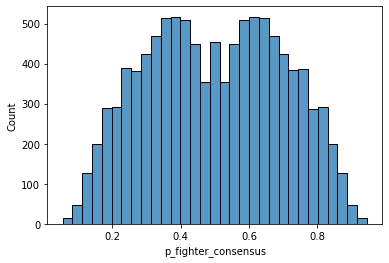

In [21]:
sns.histplot(close_feat_ml_df[p_fighter_implied_col])

In [22]:
inds = close_feat_ml_df["p_fighter_consensus"].notnull()
acc = (close_feat_ml_df.loc[inds, p_fighter_implied_col].round() == 
       close_feat_ml_df.loc[inds, "win_target"]).mean()
print(f"Moneyline consensus Accuracy: {acc:.3f}")

Moneyline consensus Accuracy: 0.672


/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/2420756458.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  close_feat_ml_df["ml_logit_mvmt"] = logit(close_feat_ml_df[p_fighter_implied_col]) - \


<AxesSubplot:>

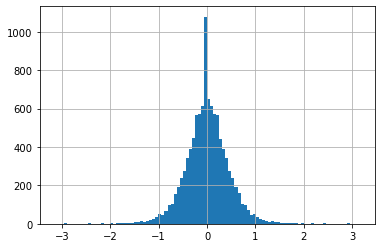

In [23]:
close_feat_ml_df["ml_logit_mvmt"] = logit(close_feat_ml_df[p_fighter_implied_col]) - \
        logit(close_feat_ml_df["p_fighter_open_implied"])

close_feat_ml_df["ml_logit_mvmt"].hist(bins=100)

In [24]:
# from wrangle.clean_bfo_data import parse_american_odds
# from scipy.special import logit

# close_df = base_db_interface.read("clean_bfo_close_data").rename(columns={
#     "FighterID": "FighterID_bfo",
#     "OpponentID": "OpponentID_bfo",
# }).drop(columns=["FighterName", "OpponentName", "match_id"])
# for market in "	DraftKings	BetMGM	Caesars	BetRivers	FanDuel	PointsBet	Unibet	Bet365	BetWay	5D	Ref".split():
#     close_df[f"p_fighter_{market}_implied"] = parse_american_odds(close_df[f"{market}_fighter"])
#     close_df[f"p_fighter_{market}_implied_logit"] = logit(close_df[f"p_fighter_{market}_implied"])

# close_df.head()

# feat_close_ml_df = feat_ml_df.merge(
#     close_df,
#     how="left",
#     on=["FighterID_bfo", "OpponentID_bfo", "EventHref"],
# )

In [25]:
close_feat_ml_df.loc[:, close_feat_ml_df.columns.str.contains("p_fighter")].isnull().mean()

p_fighter_open_implied          0.799770
p_fighter_close_implied         0.799770
p_fighter_dk_implied            0.972403
p_fighter_DraftKings_implied    0.972403
p_fighter_FanDuel_implied       0.970402
p_fighter_BetRivers_implied     0.981677
p_fighter_Unibet_implied        0.977179
p_fighter_Bet365_implied        0.943715
p_fighter_BetWay_implied        0.947850
p_fighter_consensus             0.924293
p_fighter_consensus_logit       0.924293
p_fighter_dk_logit              0.972403
p_fighter_fd_implied            0.970402
p_fighter_fd_logit              0.998602
dtype: float64

In [60]:
real_aux_target_cols = [
    "SGL_diff", "TDL_diff", "KD_diff",
    "SSL_diff", "SS_fail_diff", "TS_fail_diff", "SM_fail_diff", # commenting this out because I'm in a hurry
    "signed_inverse_fight_time",
    "percent_ctrl_time_diff",
    "cardio_diff",
    # "finish_fighter_result",
]
binary_aux_target_cols = [
    "win_target", 
    # "finish_fighter_result",
]
static_feat_cols = [
    "ape_index_diff", "bmi_diff", 
    "age_diff", "log_t_since_first_fight_diff", 
    "log_t_since_prev_fight_diff", # commenting this out because it might introduce some weirdness - I'm imputing it poorly
    "stance_diff", "total_fights_sqrt_diff", "russia_diff",
    # "is_first_fight_diff",
]

In [61]:
from model.mma_features import RealFighterPowerWrapper, BinaryFighterPowerWrapper

rfp_wrapper = RealFighterPowerWrapper(
    target_cols=real_aux_target_cols,
    static_feat_cols=static_feat_cols,

    # weight_decay=0.5,
    # reg_penalty=50,

    weight_decay=0.01,
    reg_penalty=10,

    # weight_decay=0.01,
    # reg_penalty=0.1,

    # weight_decay=0.5,
    # reg_penalty=1,

    # max_iter=100,
    # n_jobs=-1,
)

# min_date = pd.to_datetime("2005-01-01")
min_date = pd.to_datetime("2014-01-01")

rfp_feat_df = rfp_wrapper.fit_transform_all(
    close_feat_ml_df, 
    min_date=min_date,
    # max_date_fighter_id=pd.to_datetime("2022-01-01"),
    # fast=True,
)

trying again with a just one estimator, calling estimator.fit_transform_all, which just uses a for loop
fitting SGL_diff


100%|██████████| 462/462 [00:06<00:00, 66.13it/s]


fitting TDL_diff


100%|██████████| 462/462 [00:07<00:00, 58.37it/s]


fitting KD_diff


100%|██████████| 462/462 [00:06<00:00, 70.96it/s]


fitting SSL_diff


100%|██████████| 462/462 [00:06<00:00, 69.17it/s]


fitting SS_fail_diff


100%|██████████| 462/462 [00:06<00:00, 71.99it/s]


fitting TS_fail_diff


100%|██████████| 462/462 [00:06<00:00, 71.32it/s]


fitting SM_fail_diff


100%|██████████| 462/462 [00:07<00:00, 59.09it/s]


fitting signed_inverse_fight_time


100%|██████████| 2187/2187 [03:28<00:00, 10.50it/s]


fitting percent_ctrl_time_diff


100%|██████████| 2204/2204 [05:57<00:00,  6.16it/s]


fitting cardio_diff


100%|██████████| 462/462 [00:07<00:00, 63.42it/s]


In [62]:
bfp_wrapper = BinaryFighterPowerWrapper(
    target_cols=binary_aux_target_cols,
    static_feat_cols=static_feat_cols,
    
    weight_decay=0.01,
    reg_penalty=10,

    # weight_decay=0.5,
    # reg_penalty=1,

    # weight_decay=0.01,
    # reg_penalty=0.1,

    # weight_decay=0.03,
    # reg_penalty=20,

    # weight_decay=0.5,
    # reg_penalty=50,
)

bfp_feat_df = bfp_wrapper.fit_transform_all(
    close_feat_ml_df,
    min_date=min_date,
    # fast=True,
    # max_date_fighter_id=pd.to_datetime("2022-01-01"),
)

trying again with a just one estimator, calling estimator.fit_transform_all, which just uses a for loop
fitting win_target
got rid of warm_start=True


100%|██████████| 2192/2192 [58:24<00:00,  1.60s/it]


In [105]:
close_feat_ml_df[[*binary_aux_target_cols, *static_feat_cols]].isnull().mean()

win_target                      0.019072
ape_index_diff                  0.000000
bmi_diff                        0.000000
age_diff                        0.000000
log_t_since_first_fight_diff    0.000000
log_t_since_prev_fight_diff     0.000000
stance_diff                     0.000000
total_fights_sqrt_diff          0.000000
russia_diff                     0.000000
dtype: float64

In [106]:
bfp_feat_df.isnull().mean()

FighterID_espn     0.000000
OpponentID_espn    0.000000
fight_id           0.000000
win_target         0.499287
pred_win_target    0.499287
dtype: float64

# TODO

Join `rfp_feat_df` and `bfp_feat_df` with `feat_close_ml_df` in order to get the `win_target` column and closing line.

Then, follow the pattern in `closing_ML_errors`: instantiate a `SimpleSymmetricModel`, `TimeSeriesCrossVal`, and then evaluate model accuracy and log loss.

After this, I can even try using my regular `EloWrapper` classes, see how much performance gain I get from using this stuff

Also I should proabbly save this table of features somewhere

In [63]:
# dt = "06_13"
# dt = "08_11"
# dt = "08_19"
dt = "09_01"
base_db_interface.write_replace(f"real_fighter_power_features_{dt}", rfp_feat_df)
base_db_interface.write_replace(f"binary_fighter_power_features_{dt}", bfp_feat_df)

137372

In [64]:
base_db_interface.write_replace("closing_features_ml_{dt}", close_feat_ml_df)

137372

In [65]:
import sys
sys.path.append('/Users/john/play/sports/') # add parent directory to path

In [109]:
# # import numpy as np
# # import pandas as pd
# # import matplotlib.pyplot as plt
# # import seaborn as sns
# # from db import base_db_interface

# dt = "08_11"
# old_rfp_feat_df = base_db_interface.read(f"real_fighter_power_features_{dt}")
# old_bfp_feat_df = base_db_interface.read(f"binary_fighter_power_features_{dt}")
# # old_close_feat_ml_df = base_db_interface.read(f"closing_features_ml_{dt}")
# print(old_bfp_feat_df.isnull().mean())
# print(old_rfp_feat_df.isnull().mean())
# # print(old_close_feat_ml_df[[*binary_aux_target_cols, *static_feat_cols]].isnull().mean())

FighterID_espn                0.000000
OpponentID_espn               0.000000
fight_id                      0.000000
win_target                    0.513786
pred_win_target               0.504861
finish_fighter_result         0.505747
pred_finish_fighter_result    0.504861
dtype: float64
FighterID_espn                    0.000000
OpponentID_espn                   0.000000
fight_id                          0.000000
SGL_diff                          0.927304
pred_SGL_diff                     0.504861
TDL_diff                          0.927274
pred_TDL_diff                     0.504861
KD_diff                           0.927274
pred_KD_diff                      0.504861
SSL_diff                          0.927274
pred_SSL_diff                     0.504861
SS_fail_diff                      0.927274
pred_SS_fail_diff                 0.504861
TS_fail_diff                      0.927274
pred_TS_fail_diff                 0.504861
SM_fail_diff                      0.927274
pred_SM_fail_diff       

In [111]:
# # (old_bfp_feat_df["pred_win_target"].round() == old_bfp_feat_df["win_target"]).mean()
# inds = old_bfp_feat_df["win_target"].notnull()
# acc = (old_bfp_feat_df.loc[inds, "win_target"] ==
#          old_bfp_feat_df.loc[inds, "pred_win_target"].round()).mean()
# print(f"old BinaryFighterPowerWrapper accuracy: {acc:.3f}")

old BinaryFighterPowerWrapper accuracy: 0.729


In [99]:
# accuracy of bfp_feat_df
# low returns: acc 0.737
# higher returns: acc 
inds = bfp_feat_df["win_target"].notnull()
acc = (bfp_feat_df.loc[inds, "win_target"] ==
         bfp_feat_df.loc[inds, "pred_win_target"].round()).mean()
print(f"BinaryFighterPowerWrapper accuracy: {acc:.3f}")

BinaryFighterPowerWrapper accuracy: 0.737


In [104]:
bfp_feat_df.isnull().mean(), bfp_feat_df.shape

(FighterID_espn     0.000000
 OpponentID_espn    0.000000
 fight_id           0.000000
 win_target         0.499287
 pred_win_target    0.499287
 dtype: float64,
 (137372, 5))

In [68]:
rfp_feat_df.head()

,FighterID_espn,OpponentID_espn,fight_id,SGL_diff,pred_SGL_diff,TDL_diff,pred_TDL_diff,KD_diff,pred_KD_diff,SSL_diff,...,TS_fail_diff,pred_TS_fail_diff,SM_fail_diff,pred_SM_fail_diff,signed_inverse_fight_time,pred_signed_inverse_fight_time,percent_ctrl_time_diff,pred_percent_ctrl_time_diff,cardio_diff,pred_cardio_diff
0,2558095,2354059,1991-09-26_2354059_2558095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2354059,2558095,1991-09-26_2354059_2558095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2354119,2501396,1992-01-01_2354119_2501396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2501396,2354119,1992-01-01_2354119_2501396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2354132,3107994,1993-08-29_2354132_3107994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='pred_signed_inverse_fight_time', ylabel='signed_inverse_fight_time'>

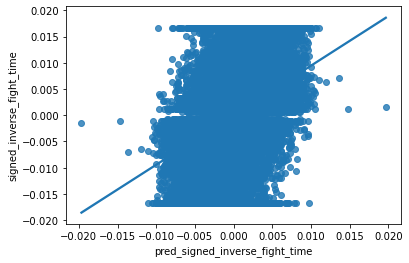

In [69]:
# hey, that's pretty good
sns.regplot(
    data=rfp_feat_df,
    x="pred_signed_inverse_fight_time",
    y="signed_inverse_fight_time",
    # lowess=True,
)

In [70]:
foo = rfp_feat_df.dropna(subset=["pred_signed_inverse_fight_time", "signed_inverse_fight_time"])
y = foo["signed_inverse_fight_time"] > 0
# y = foo["win_target"]
y_pred = foo["pred_signed_inverse_fight_time"] > 0
print("Accuracy:", (y == y_pred).mean())

Accuracy: 0.7322638094125891


In [112]:
final_feat_close_ml_df = close_feat_ml_df.merge(
    rfp_feat_df,
    # old_rfp_feat_df,
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
).merge(
    bfp_feat_df,
    # old_bfp_feat_df,
    how="left",
    on=["fight_id", "FighterID_espn", "OpponentID_espn"],
)
final_feat_close_ml_df.head()

,fight_id,Date_legacy,FighterResult,Decision,Rnd,Time,Event,OpponentID_espn,FighterID_espn,TSL,...,signed_inverse_fight_time_y,pred_signed_inverse_fight_time,percent_ctrl_time_diff_y,pred_percent_ctrl_time_diff,cardio_diff_y,pred_cardio_diff,win_target_y,pred_win_target,finish_fighter_result_y,pred_finish_fighter_result
0,1991-09-26_2354059_2558095,1991-09-26,L,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2354059,2558095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-09-26_2354059_2558095,1991-09-26,W,TKO (Injury),1,4:42,Desafio: Jiu-Jitsu vs. Luta Livre,2558095,2354059,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992-01-01_2354119_2501396,1992-01-01,W,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2501396,2354119,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1992-01-01_2354119_2501396,1992-01-01,L,Submission (Rear Naked Choke),1,7:03,Desafio: Gracie Vale Tudo,2354119,2501396,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-29_2354132_3107994,1993-08-29,W,Submission (Strikes),1,2:46,CP X CB: Capoeira vs. Chute Boxe,3107994,2354132,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
feat_cols = [
    *[f"pred_{col}" for col in real_aux_target_cols],
    *[f"pred_{col}" for col in binary_aux_target_cols],
    *static_feat_cols,
]
final_feat_close_ml_df[feat_cols].isnull().mean()

pred_SGL_diff                     0.520819
pred_TDL_diff                     0.520819
pred_KD_diff                      0.520819
pred_SSL_diff                     0.520819
pred_SS_fail_diff                 0.520819
pred_TS_fail_diff                 0.520819
pred_SM_fail_diff                 0.520819
pred_signed_inverse_fight_time    0.520819
pred_percent_ctrl_time_diff       0.520819
pred_cardio_diff                  0.520819
pred_win_target                   0.520819
ape_index_diff                    0.000000
bmi_diff                          0.000000
age_diff                          0.000000
log_t_since_first_fight_diff      0.000000
log_t_since_prev_fight_diff       0.000000
stance_diff                       0.000000
total_fights_sqrt_diff            0.000000
russia_diff                       0.000000
dtype: float64

In [114]:
final_feat_close_ml_df["win_target"] = final_feat_close_ml_df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})

/var/folders/9d/jpvr10fs6jb7vfqnwlqck0kc0000gq/T/ipykernel_7805/3999921217.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_feat_close_ml_df["win_target"] = final_feat_close_ml_df["FighterResult"].replace({"W":1, "L":0, "D":np.nan})


In [115]:
(final_feat_close_ml_df["win_target"] == (final_feat_close_ml_df["pred_win_target"] > 0.5)).mean()

0.5982005066534665

In [116]:
foo = final_feat_close_ml_df.query("Date > '2022-01-01'")
(foo["win_target"] == (foo["pred_win_target"] > 0.5)).mean()

0.5992366412213741

<AxesSubplot:>

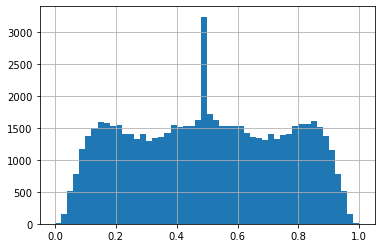

In [117]:
final_feat_close_ml_df["pred_win_target"].hist(bins=50)

# Closing line

In [118]:
# p_fighter_implied_col = "p_fighter_consensus"
# p_fighter_implied_col = None

In [119]:
from model.mma_lgbm import MmaLightGBM
from lightgbm import early_stopping

mod = MmaLightGBM(
    feat_cols = feat_cols + [p_fighter_implied_col, "ml_logit_mvmt", "fight_weight", "is_ufc"],
    # feat_cols=feat_cols + [p_fighter_implied_col],
    # feat_cols = feat_cols,
    target_col="win_target",
    p_fighter_implied_col=p_fighter_implied_col,
    p_valid=0.1,
    early_stopping_rounds=1000,
    learning_rate=0.005,
    # reg_alpha=5,
)

dis right here is a test


In [120]:
from model_selection.cross_val_pipeline import TimeSeriesCrossVal

train_df = final_feat_close_ml_df.dropna(subset=[
    *feat_cols, "win_target", p_fighter_implied_col, 
]).query("Date >= '2014-01-01'").drop_duplicates(
    subset=["fight_id", "FighterID_espn", "OpponentID_espn"]
)
# train_df = train_df.query("is_ufc == 1")
drop_fight_id = train_df["fight_id"].value_counts() == 1
fight_ids_to_drop = drop_fight_id[drop_fight_id].index
train_df = train_df[~train_df["fight_id"].isin(fight_ids_to_drop)]

tscv = TimeSeriesCrossVal(min_test_date=pd.to_datetime("2022-01-01"), 
                          n_dates_per_fold=1, 
                          p_fighter_implied_col=p_fighter_implied_col)
preds_df = tscv.get_cross_val_preds(
    mod,
    train_df
)

Can you read this?
training on date range: 2018-10-06 2021-12-30
training on date range: 2018-10-06 2022-01-12
training on date range: 2018-10-06 2022-01-14
training on date range: 2018-10-06 2022-01-15
training on date range: 2018-10-06 2022-01-21
training on date range: 2018-10-06 2022-01-22
training on date range: 2018-10-06 2022-01-28
training on date range: 2018-10-06 2022-01-29
training on date range: 2018-10-06 2022-02-03
training on date range: 2018-10-06 2022-02-04
training on date range: 2018-10-06 2022-02-05
training on date range: 2018-10-06 2022-02-06
training on date range: 2018-10-06 2022-02-11
training on date range: 2018-10-06 2022-02-12
training on date range: 2018-10-06 2022-02-18
training on date range: 2018-10-06 2022-02-19
training on date range: 2018-10-06 2022-02-23
training on date range: 2018-10-06 2022-02-25
training on date range: 2018-10-06 2022-02-26
training on date range: 2018-10-06 2022-02-27
training on date range: 2018-10-06 2022-03-04
training on dat

In [121]:
preds_df.columns

Index(['fight_id', 'Date_legacy', 'FighterResult', 'Decision', 'Rnd', 'Time',
       'Event', 'OpponentID_espn', 'FighterID_espn', 'TSL',
       ...
       'pred_percent_ctrl_time_diff', 'cardio_diff_y', 'pred_cardio_diff',
       'win_target_y', 'pred_win_target', 'finish_fighter_result_y',
       'pred_finish_fighter_result', 'win_target', 'y_pred', 'test_fold'],
      dtype='object', length=409)

In [122]:
from sklearn.metrics import log_loss, accuracy_score

# low returns -> 0.6928184380180115
# high returns -> 0.6514175482792739
xe = log_loss(
    preds_df["win_target"],
    preds_df["pred_win_target"],
)
print(f"Cross-entropy: {xe:.3f}")
acc = accuracy_score(
    preds_df["win_target"],
    preds_df["pred_win_target"].round(),
)
print(f"Accuracy: {acc:.3f}")

Cross-entropy: 0.651
Accuracy: 0.609


In [123]:
mod_pred = preds_df["y_pred"].round()
ml_pred = preds_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == preds_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == preds_df["win_target"]).mean())

from sklearn.metrics import log_loss

xce = log_loss(y_true=preds_df["win_target"], y_pred=preds_df["y_pred"])
xce_ml = log_loss(y_true=preds_df["win_target"], y_pred=preds_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Moneyline log loss: {xce_ml}")

y_true = preds_df["win_target"]
y_pred = preds_df["y_pred"]
y_pred_ml = preds_df[p_fighter_implied_col]
xce_vals = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
xce_ml_vals = y_true * np.log(y_pred_ml) + (1 - y_true) * np.log(1 - y_pred_ml)
# sns.histplot(xce_vals, bins=100, color="blue", alpha=0.5)
# sns.histplot(xce_ml_vals, bins=100, color="red", alpha=0.5)
# plt.legend(["model", "Moneyline"])
# plt.show()
np.mean(xce_vals - xce_ml_vals) / (np.std(xce_vals - xce_ml_vals) / np.sqrt(len(xce_vals)))

Model accuracy:      0.6821305841924399
Moneyline accuracy:  0.6764032073310424
model log loss    : 0.5799196854642934
Moneyline log loss: 0.5911402069318643


6.338946440689294

In [124]:
preds_df["week"] = preds_df["Date"].dt.isocalendar().week
preds_df["Date_fight"] = preds_df["Date"].astype(str) + preds_df["fight_id"]

In [125]:
preds_df.columns[preds_df.columns.str.contains("fight_id")]

Index(['fight_id'], dtype='object')

100%|██████████| 1746/1746 [00:19<00:00, 88.52it/s]


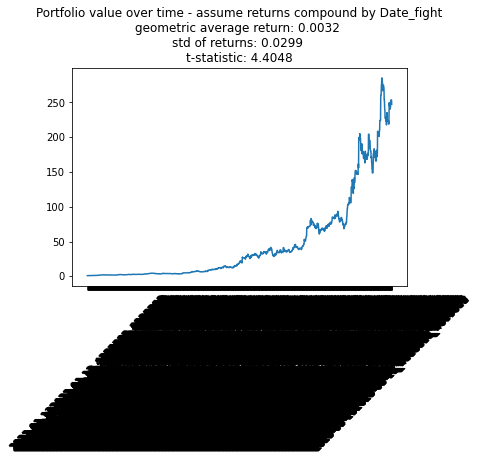

In [126]:
from model_selection.backtesting import MultiKellyPortfolioManager, TradingSimulator

# fighter_ml_col = "DraftKings_fighter"
# opponent_ml_col = "DraftKings_opponent"
fighter_ml_col = "best_fighter_price"
opponent_ml_col = "best_opponent_price"
# fighter_ml_col = "FanDuel_fighter"
# opponent_ml_col = "FanDuel_opponent"

kwargs = {
    "fighter_ml_col": fighter_ml_col,
    "opponent_ml_col": opponent_ml_col,
}

kelly_pm = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts = TradingSimulator(kelly_pm, **kwargs)
ts.simulate_trading(preds_df, bet_ts_col="Date_fight", payout_ts_col="Date_fight")
# ts.returns_df
ts.plot_diagnostics()

In [127]:
ufc_df = preds_df.query("is_ufc == 1")

mod_pred = ufc_df["y_pred"].round()
ml_pred = ufc_df[p_fighter_implied_col].round()
print("Model accuracy:     ", (mod_pred == ufc_df["win_target"]).mean())
print("Moneyline accuracy: ", (ml_pred == ufc_df["win_target"]).mean())

from sklearn.metrics import log_loss

xce = log_loss(y_true=ufc_df["win_target"], y_pred=ufc_df["y_pred"])
xce_ml = log_loss(y_true=ufc_df["win_target"], y_pred=ufc_df[p_fighter_implied_col])

print(f"model log loss    : {xce}")
print(f"Moneyline log loss: {xce_ml}")

y_true = ufc_df["win_target"]
y_pred = ufc_df["y_pred"]
y_pred_ml = ufc_df[p_fighter_implied_col]
xce_vals = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
xce_ml_vals = y_true * np.log(y_pred_ml) + (1 - y_true) * np.log(1 - y_pred_ml)
# sns.histplot(xce_vals, bins=100, color="blue", alpha=0.5)
# sns.histplot(xce_ml_vals, bins=100, color="red", alpha=0.5)
# plt.legend(["model", "Moneyline"])
# plt.show()
np.mean(xce_vals - xce_ml_vals) / (np.std(xce_vals - xce_ml_vals) / np.sqrt(len(xce_vals)))

Model accuracy:      0.6601503759398496
Moneyline accuracy:  0.6586466165413534
model log loss    : 0.6035721679675394
Moneyline log loss: 0.6075083279931474


1.9926122039318115

In [128]:
ufc_df.query("is_ufc == 1")["Date"].max()

Timestamp('2023-05-13 00:00:00')

In [129]:
# event_return_df = ts1.return_df.groupby(x_col)["final_portfolio_value"].max()\
#             .reset_index()\
#             .rename(columns={"final_portfolio_value": "portfolio_value"})

100%|██████████| 665/665 [00:07<00:00, 88.48it/s]


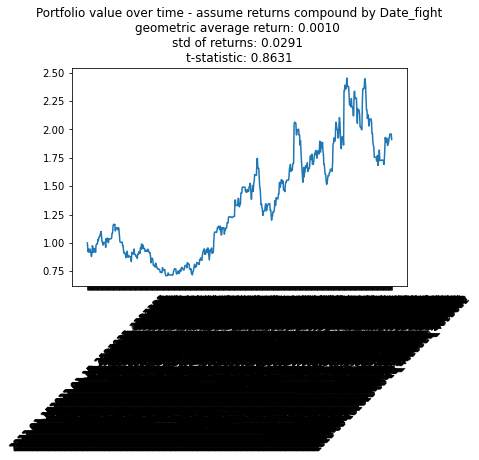

In [130]:
kelly_pm1 = MultiKellyPortfolioManager(max_bankroll_fraction=0.05, **kwargs)
ts1 = TradingSimulator(kelly_pm1, **kwargs)
ts1.simulate_trading(preds_df.query("is_ufc == 1"), bet_ts_col="Date_fight", payout_ts_col="Date_fight")
ts1.plot_diagnostics()
# ts1.returns_df["final_portfolio_value"].plot()

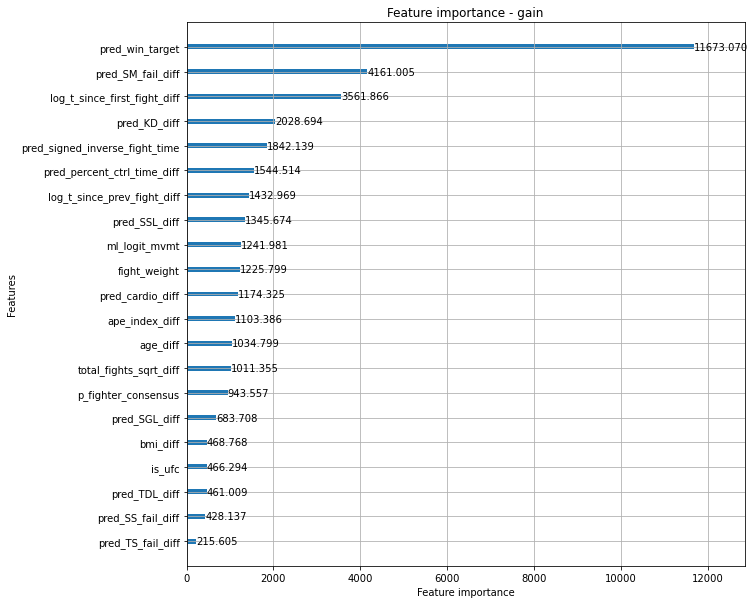

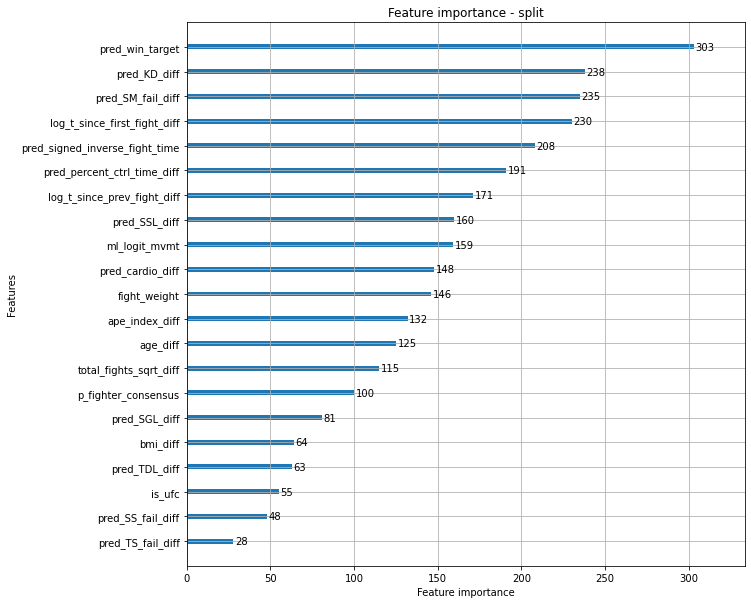

In [131]:
from lightgbm import plot_importance

plot_importance(mod.model, figsize=(10, 10), importance_type="gain")
plt.title("Feature importance - gain")
plt.show()
plot_importance(mod.model, figsize=(10, 10))
plt.title("Feature importance - split")
plt.show()

In [132]:
# low returns: acc 0.5628672150411281
# higher returns: acc 0.6088201603665521
# there must be a bug in pred_win_target!
(preds_df["pred_win_target"].round() == preds_df["win_target"]).mean()

0.6088201603665521

In [133]:
close_feat_ml_df.query("FighterID_espn == '2504169'")[["FighterName", "OpponentName", 
                                             "p_fighter_open_implied", "Date",
                                             "p_fighter_consensus",]]

,FighterName,OpponentName,p_fighter_open_implied,Date,p_fighter_consensus
20793,charles oliveira,diego braga,NaN,2008-03-15,NaN
20808,charles oliveira,viscardi andrade,NaN,2008-03-15,NaN
20851,charles oliveira,jackson pontes,NaN,2008-03-15,NaN
25279,charles oliveira,mehdi baghdad,NaN,2008-12-13,NaN
25402,charles oliveira,elieni silva,NaN,2008-12-29,NaN
25403,charles oliveira,daniel fernandes,NaN,2008-12-29,NaN
26612,charles oliveira,carlos soares,NaN,2009-03-21,NaN
27108,charles oliveira,dom stanco,NaN,2009-04-17,NaN
29984,charles oliveira,alexandre bezerra,NaN,2009-09-18,NaN
30221,charles oliveira,eduardo pachu,NaN,2009-09-26,NaN


# Upcoming fights, 2023-08-19

In [134]:
# from wrangle.clean_bfo_data import parse_american_odds

train_df = final_feat_close_ml_df.dropna(subset=[
    *feat_cols, "win_target", p_fighter_implied_col, 
]).query("Date >= '2014-01-01'").drop_duplicates(
    subset=["fight_id", "FighterID_espn", "OpponentID_espn"]
).query("is_upcoming == 0")

test_df = final_feat_close_ml_df.query("is_upcoming == 1").drop_duplicates(
    subset=["fight_id", "FighterID_espn", "OpponentID_espn"]
)
train_df.shape, test_df.shape

((9247, 407), (130, 407))

In [135]:
mod = MmaLightGBM(
    feat_cols = feat_cols + [p_fighter_implied_col, "ml_logit_mvmt", "fight_weight", "is_ufc"],
    # feat_cols=feat_cols + [p_fighter_implied_col],
    # feat_cols = feat_cols,
    target_col="win_target",
    p_fighter_implied_col=p_fighter_implied_col,
    p_valid=0.1,
    early_stopping_rounds=1000,
    learning_rate=0.005,
    # reg_alpha=5,
)

y_pred = mod.fit_predict(train_df, test_df, feat_cols)
y_pred

dis right here is a test


AssertionError: 

In [ ]:
preds_df = test_df.assign(y_pred = y_pred)
preds_df[["FighterName", "OpponentName", 
          "FighterOpen", "OpponentOpen", 
          p_fighter_implied_col, "y_pred"]]

NameError: name 'test_df' is not defined

In [ ]:
from scrape.scrape_bfo import EventScraper
upcoming_urls = [
    'https://www.bestfightodds.com/events/ufc-292-sterling-vs-o-malley-2899',
    'https://www.bestfightodds.com/events/ufc-2990',
]
event_df = []
for url in upcoming_urls:
    scraper = EventScraper(url)
    event_df.append(scraper.get_odds())
event_df = pd.concat(event_df)

In [ ]:
# ah geez look at 2023-04-10_base_template.ipynb for the rest of this